# Workout Metrics Data Analysis
## Table of Contents
1. [Setup Packages and Config](#setup-packages-and-config)
2. [Import Data](#import-data)
3. [Clean the Data](#clean-the-data)
   - [Flatten Nested Columns](#flatten-nested-columns)
   - [Convert Dates to DateTime](#convert-dates-to-datetime)
4. [Validate and Save Cleaned Data](#validate-and-save-cleaned-data)
5. [Preparing for Data Analysis](#data-analysis)

# 1. Setup Packages and Config 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Import Data

In [2]:
# Load the JSON data
data = pd.read_json('../original_data/data.json')["data"]

# Extract 'workouts' DataFrame from the JSON data
wdf = pd.DataFrame(data["workouts"])

# 3. Clean the Data
## 3.1 Flatten Nested Columns

In [3]:
# Flatten the nested columns in the 'workouts' DataFrame
def extract_qty_column(df, column_name):
    if column_name in df.columns:
        df[f'{column_name}_qty'] = df[column_name].apply(lambda x: x['qty'] if isinstance(x, dict) else x)
    else:
        df[f'{column_name}_qty'] = np.nan
    return df

# Extract the qty from all relevant columns
columns_to_extract = ['activeEnergyBurned', 'distance', 'lapLength', 'intensity', 'humidity', 'temperature']
for column_name in columns_to_extract: 
    wdf = extract_qty_column(wdf, column_name)

# Drop the original columns
wdf.drop(columns=columns_to_extract, axis=1, inplace=True)

## 3.2 Convert Dates to DateTime


In [4]:
# Convert Dates to DateTime objects
wdf['start'] = pd.to_datetime(wdf['start'], format='%Y-%m-%d %H:%M:%S %z')
wdf['end'] = pd.to_datetime(wdf['end'], format='%Y-%m-%d %H:%M:%S %z')
# Count the number of missing values in each column 
print(wdf.isnull().sum())

id                          0
name                        0
start                       0
end                         0
duration                    0
location                  250
activeEnergyBurned_qty      2
distance_qty              237
lapLength_qty             379
intensity_qty              12
humidity_qty              133
temperature_qty           133
dtype: int64


# 4. Validate and Save Cleaned Data

In [5]:
# Validate cleaned data
print(wdf.head()) 
# Save the cleaned data
wdf.to_csv('../cleaned_data/cl_workouts.csv', index=False)

                                     id                              name  \
0  1A92CCA1-80B0-4C44-9FA5-DD5A2756478C                     Core Training   
1  BAD3330A-E7F0-4C54-9257-43075838357D  High Intensity Interval Training   
2  00DA3796-BA60-42EB-B28A-74AD67C5C1B5                   Outdoor Cycling   
3  AC234210-6900-45E3-A39F-7EF6505914FE  High Intensity Interval Training   
4  2FE239D9-3311-4C24-8A4B-C876EEAC64FB  High Intensity Interval Training   

                      start                       end    duration location  \
0 2021-03-11 07:03:11-10:00 2021-03-11 07:14:18-10:00  636.608887      NaN   
1 2021-03-24 14:44:10-10:00 2021-03-24 14:51:11-10:00  421.000305      NaN   
2 2021-03-26 03:31:24-10:00 2021-03-26 03:40:00-10:00  515.888359  Outdoor   
3 2021-04-01 11:30:19-10:00 2021-04-01 11:54:35-10:00  948.742759      NaN   
4 2021-04-06 10:28:53-10:00 2021-04-06 10:34:36-10:00    5.955130      NaN   

   activeEnergyBurned_qty  distance_qty  lapLength_qty  intensity_qt

# 5. Data Analysis
#### Find important statistics including count, mean, and standard deviation of each metric.

In [6]:
# Group by metric for visualization/analysis
grouped = wdf.groupby('name')
print(grouped['duration'].describe())
# print(grouped['activeEnergyBurned_qty'].describe())

                                  count          mean          std  \
name                                                                 
Basketball                          1.0  10506.825593          NaN   
Core Training                      97.0   2536.226409  1687.250110   
Elliptical                          1.0    627.529041          NaN   
Functional Strength Training       39.0   2330.627565  2033.770084   
High Intensity Interval Training   22.0   1056.549210   768.057193   
Indoor Run                         51.0    921.699124   440.310341   
Indoor Walk                        15.0   2063.106654   806.317914   
Jump Rope                          11.0   1194.731657   904.075090   
Outdoor Cycling                     1.0    515.888359          NaN   
Outdoor Run                        40.0   1646.980422  1008.604087   
Outdoor Walk                       22.0   2381.265060  1383.558978   
Pool Swim                          23.0   4029.425850   862.704443   
Stair Climbing      

#### Find and display the correlation matrix. This shows the correlation between any health metrics

In [7]:
# Pivot data for correlation analysis
# pivoted_df = wdf.pivot(index='date', columns='metric', values='value')
pivoted_df = wdf[["id", "duration", "activeEnergyBurned_qty", "intensity_qty"]].set_index("id")
# Calculate correlations
correlation_matrix = pivoted_df.corr()
print(correlation_matrix)

                        duration  activeEnergyBurned_qty  intensity_qty
duration                1.000000                0.835069      -0.301745
activeEnergyBurned_qty  0.835069                1.000000       0.071605
intensity_qty          -0.301745                0.071605       1.000000


#### Find linear regression to help understand and predict the relationship between a dependent var (target) and one or more independent vars (predictors)

Mean Squared Error: 6044.689726412053
Model Coefficients: [0.09457552]


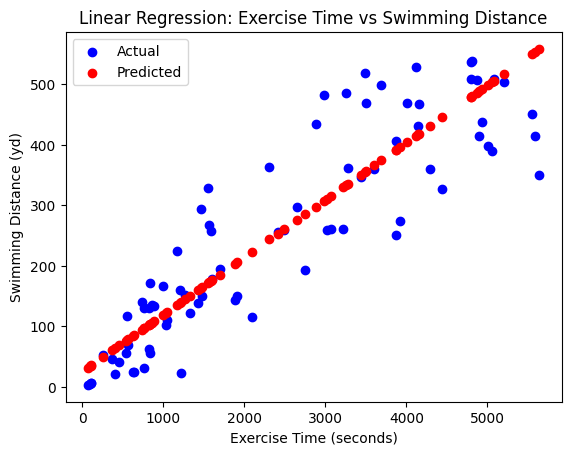

In [8]:
from functions import linear_regression
linear_regression(pivoted_df, 'duration', 'activeEnergyBurned_qty')

#### Analyze trends overtime to understand the shape of the data and predict near-future trends

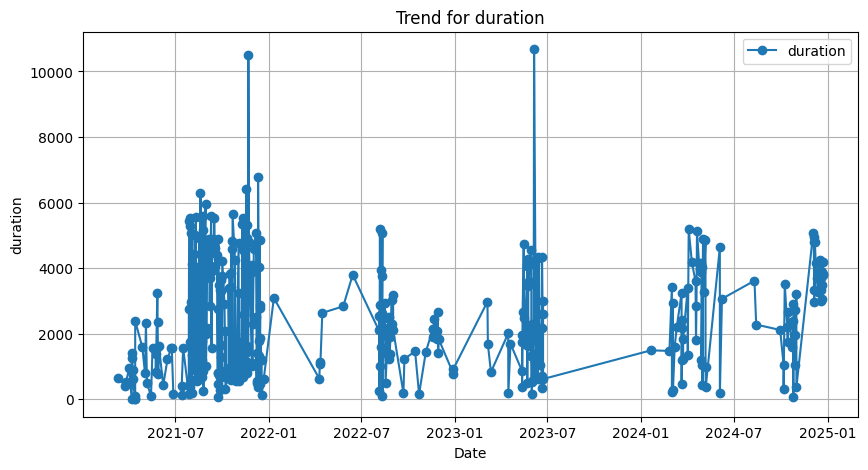

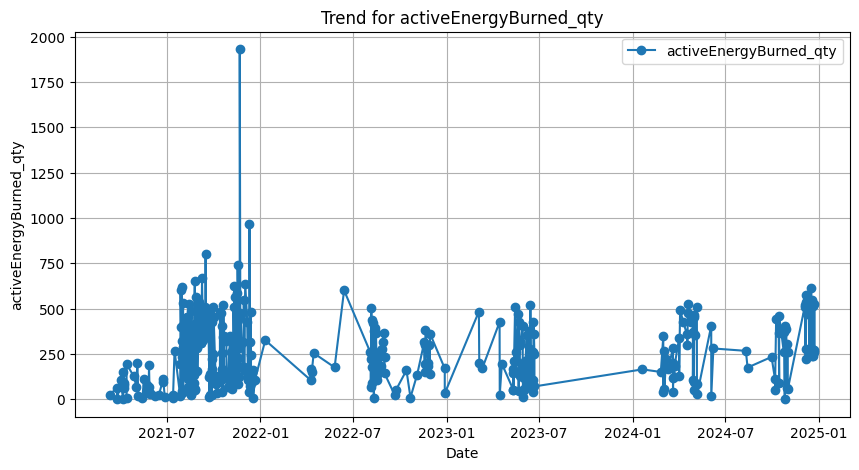

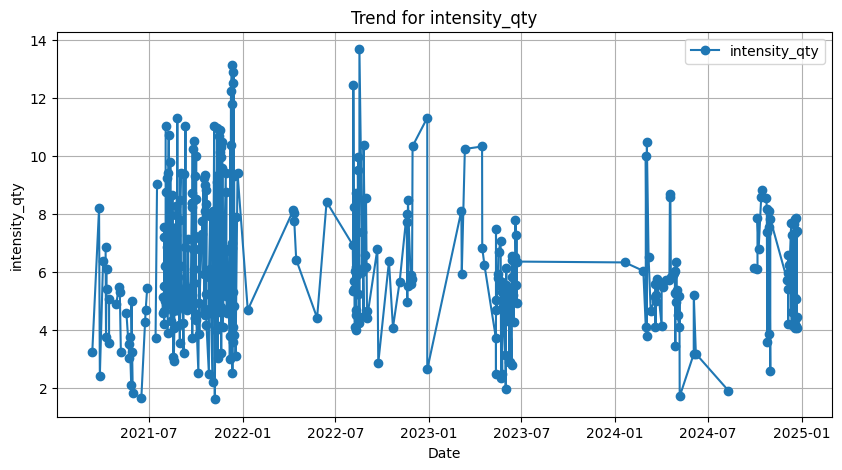

In [9]:
from functions import plot_workout_trends

# Plot trends for each metric
metrics_to_plot = ["duration", "activeEnergyBurned_qty", "intensity_qty"]
for metric in metrics_to_plot:
    plot_workout_trends(wdf, metric, ylabel=metric)

#### Analyze the correlation between two specific metrics at a time

Correlation between duration and activeEnergyBurned_qty: 0.8350688172954933


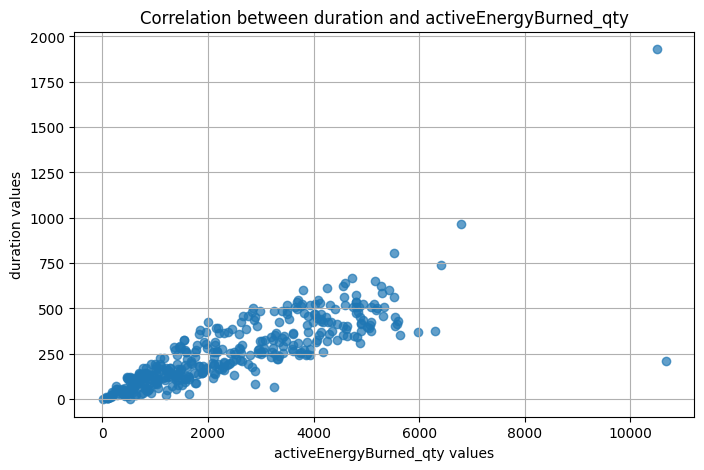

Correlation between activeEnergyBurned_qty and intensity_qty: 0.07160518433998633


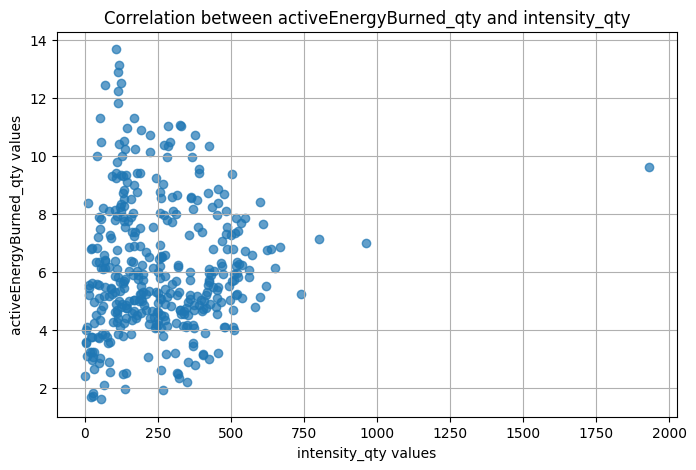

In [10]:
from functions import analyze_workout_correlation

# Flattened data as created earlier (workouts_df)
analyze_workout_correlation(wdf, "duration", "activeEnergyBurned_qty", show_plot=True)
analyze_workout_correlation(wdf, "activeEnergyBurned_qty", "intensity_qty", show_plot=True)
